In [1]:
from random import choice, randint
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from tqdm import tqdm 
import Levenshtein

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from models import Classifier

from faerun import Faerun
import tmap as tm

from rdkit import Chem
from map4 import MAP4Calculator

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Define helper functions

In [2]:
def isNonNatural(seq:str) -> int: 
    """
    Determine if a sequence is composed of natural amino acids only or not. 
    """
    aa_list = ['a','v', 'i', 'l', 'm', 'f', 'y', 'w', 'r', 'h', 'k', 'd', 'e', 's', 't', 'n', 'q', 'c', 'g', 'p', 'x', 'X']
    if any(aa in seq for aa in aa_list):
        return 1
    else:
        return 0

def isMultimer(seq:str) -> int:
    """
    Determine if an entry from DBAASP is a multimer (e.g. KKKLLLLKKKLLL,KKKLLLLKKKLLL). 
    """
    if ',' in seq:
        return 1
    else:
        return 0
        
def isActive(row:pd.DataFrame) -> str:
    """
    Determine if an entry from DBAASP is active. The thresholds are given in μg/ml and can be adjusted. 
    Values lower than the threshold are regarded as active; values higher than the threshold are regarded as inactive.
    """
    if row.Activity == 0:
        return 'Active'
    else:
        if row.Activity <= 4:
            return 'Active'
        else:
            return 'Inactive'

def isNotHemolytic(row:pd.DataFrame) -> str:
    """
    Determine if an entry from DBAASP is hemolytic. The thresholds are given in μg/ml and can be adjusted. 
    Values lower than the threshold are regarded as hemolytic; values higher than the threshold are regarded as non hemolytic.
    """
    if row.Hemolysis == 0:
        return 'Hemolytic'
    else:
        if row.Hemolysis >= 200:
            return 'Not Hemolytic'
        else:
            return 'Hemolytic'

def Length(seq:str) -> int:
    """
    Determine length of a sequence
    """
    return len(seq)


def RemoveSpace(seq:str) -> str:
    """
    Remove spaces from sequences (e.g.' KKKLLL' --> 'KKKLLL')
    """
    return seq.replace(' ', '')


def RangeRandomSequence(AA_list:list, min_length:int, max_length:int) -> str:
    """
    Generates a random sequence starting from an input amino acid list (AA_list) with sequence length between min_length and max_length.
    """
    sequence = ''
    length = randint(min_length, max_length)
    for aa in range(length):
        sequence += choice(AA_list)
    return sequence


def AnalyzeComposition(seq_list:list) -> np.ndarray:
    """
    Returns array with counts of each amino acid.
    """
    AA_list = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
    aa_counts = np.zeros(len(AA_list))

    for idx, aa in enumerate(AA_list):
        for seq in seq_list:
            aa_counts[idx] = aa_counts[idx] + seq.count(aa)
    return aa_counts


def AnalyzeCompositionFraction(seq_list:list) -> np.ndarray:
    """
    Returns array with mean fraction of each amino acid and standard deviation.
    """
    AA_list = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
    fracs_aa = np.zeros(len(seq_list))
    fracs_mean = np.zeros(len(AA_list))
    fracs_std = np.zeros(len(AA_list))

    for i, aa in enumerate(AA_list):
        for j, seq in enumerate(seq_list):
            fracs_aa[j] = seq.count(aa)/len(seq)
        fracs_mean[i] = np.mean(fracs_aa)
        fracs_std[i] = np.std(fracs_aa)
    return fracs_mean, fracs_std

#### Import all the sets: DBAASP, RNN selection, PDGA selection and generate a set of random peptides

Import entire DBAASP and keep calculated activity (μg/ml) and hemolysis (μg/ml) columns

In [3]:
dbaasp_complete = pd.read_csv('data/peptides-complete.csv', low_memory=False)
dbaasp_complete = dbaasp_complete[[
    'ID', 
    'SEQUENCE', 
    'TARGET ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)', 
    'HEMOLITIC CYTOTOXIC ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)'
    ]]

dbaasp_complete = dbaasp_complete.rename(columns={
    'SEQUENCE': 'Sequence', 
    'TARGET ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)': 'Activity', 
    'HEMOLITIC CYTOTOXIC ACTIVITY - ACTIVITY (μg/ml) (Calculated By DBAASP)': 'Hemolysis',
    })

Clean up DBAASP

In [4]:
dbaasp = dbaasp_complete[['ID', 'Sequence']].dropna(subset=['Sequence'])
dbaasp['isMultimer'] = dbaasp.Sequence.apply(isMultimer)
dbaasp = dbaasp[dbaasp['isMultimer'] == 0]
dbaasp = dbaasp.drop_duplicates(subset=['ID', 'Sequence'])
dbaasp['Sequence'] = dbaasp.Sequence.apply(RemoveSpace)
dbaasp['isNonNatural'] = dbaasp.Sequence.apply(isNonNatural)
dbaasp = dbaasp[dbaasp['isNonNatural'] == 0]
dbaasp = dbaasp.sort_values(by='ID')
dbaasp = dbaasp[['ID', 'Sequence']]
dbaasp['Length'] = dbaasp.Sequence.apply(Length)
dbaasp = dbaasp[dbaasp['Length'] >= 5]
dbaasp = dbaasp.reset_index(drop=True)
dbaasp['Set'] = 'DBAASP'
dbaasp = dbaasp[['Sequence', 'Set', 'Length']]
dbaasp = dbaasp.drop_duplicates(subset=['Sequence']).copy()

DBAASP: bar plot of total amino acid counts

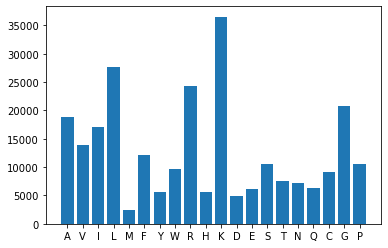

In [5]:
dbaasp_seq_list = dbaasp.Sequence.values.tolist()
dbaasp_aa_counts = AnalyzeComposition(dbaasp_seq_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

plt.bar(aa_labels, dbaasp_aa_counts)
plt.savefig('plots/barplots/dbaasp_aa_distribution.pdf')

DBAASP: mean fractions and standard deviations of each amino acid

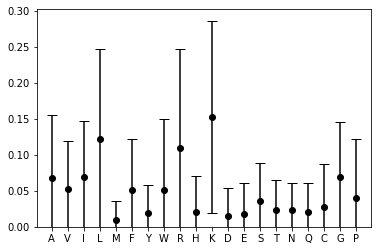

In [6]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))
dbaasp_mean, dbaasp_std = AnalyzeCompositionFraction(dbaasp_seq_list)

fig, ax = plt.subplots()
ax.errorbar(x_pos, dbaasp_mean, yerr=dbaasp_std, fmt='o', color='black', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/dbaasp_aafraction_distribution_stdev.pdf')

Select DBAASP actives and keep the highest activity. Split into actives and inactives according to thresholds defined in the helper function.

In [7]:
dbaasp_activity = dbaasp_complete.dropna(subset=['Activity'])
dbaasp_activity = dbaasp_activity.sort_values(by='Activity')
dbaasp_activity['isMultimer'] = dbaasp_activity.Sequence.apply(isMultimer)
dbaasp_activity = dbaasp_activity[dbaasp_activity['isMultimer'] == 0]
dbaasp_activity = dbaasp_activity.drop_duplicates(subset=['ID', 'Sequence'])
dbaasp_activity['Sequence'] = dbaasp_activity.Sequence.apply(RemoveSpace)
dbaasp_activity['isNonNatural'] = dbaasp_activity.Sequence.apply(isNonNatural)
dbaasp_activity = dbaasp_activity[dbaasp_activity['isNonNatural'] == 0]
dbaasp_activity = dbaasp_activity.sort_values(by='ID')
dbaasp_activity = dbaasp_activity[['ID', 'Sequence', 'Activity']]
dbaasp_activity['isActive'] = dbaasp_activity.apply(isActive, axis=1)
dbaasp_activity['Length'] = dbaasp_activity.Sequence.apply(Length)
dbaasp_activity = dbaasp_activity[dbaasp_activity['Length'] >= 5]
dbaasp_activity = dbaasp_activity.reset_index(drop=True)

DBAASP actives

In [8]:
dbaasp_actives = dbaasp_activity[dbaasp_activity['isActive'] == 'Active'].copy()
dbaasp_actives['Set'] = 'Active'
dbaasp_actives = dbaasp_actives[['Sequence', 'Set', 'Length']]

DBAASP actives: bar plot of total amino acid counts

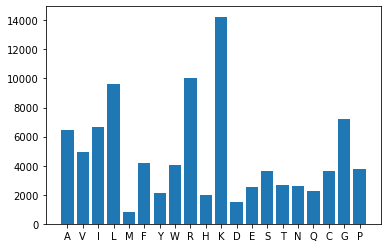

In [9]:
actives_seq_list = dbaasp_actives.Sequence.values.tolist()
actives_aa_counts = AnalyzeComposition(actives_seq_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

plt.bar(aa_labels, actives_aa_counts)
plt.savefig('plots/barplots/actives_aa_distribution.pdf')

DBAASP actives: mean fractions and standard deviations of each amino acid

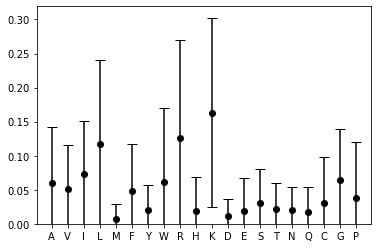

In [10]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))
actives_mean, actives_std = AnalyzeCompositionFraction(actives_seq_list)

fig, ax = plt.subplots()
ax.errorbar(x_pos, actives_mean, yerr=actives_std, fmt='o', color='black', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/actives_aafraction_distribution_stdev.pdf')

DBAASP inactives

In [11]:
dbaasp_inactives = dbaasp_activity[dbaasp_activity['isActive'] == 'Inactive'].copy()
dbaasp_inactives['Set'] = 'Inactive'
dbaasp_inactives = dbaasp_inactives[['Sequence', 'Set', 'Length']]

DBAASP inactives: bar plot of total amino acid counts

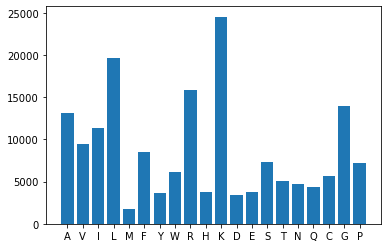

In [12]:
inactives_seq_list = dbaasp_inactives.Sequence.values.tolist()
inactives_aa_counts = AnalyzeComposition(inactives_seq_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

plt.bar(aa_labels, inactives_aa_counts)
plt.savefig('plots/barplots/inactives_aa_distribution.pdf')

DBAASP inactives: mean fractions and standard deviations of each amino acid

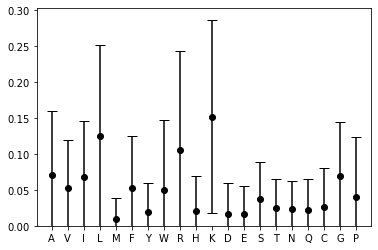

In [13]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))
inactives_mean, inactives_std = AnalyzeCompositionFraction(inactives_seq_list)

fig, ax = plt.subplots()
ax.errorbar(x_pos, inactives_mean, yerr=inactives_std, fmt='o', color='black', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/inactives_aafraction_distribution_stdev.pdf')

Select DBAASP hemolytics and keep the least hemolytic. Split into hemolytic and non hemolytic according to threshold defined in the helper function above.

In [14]:
dbaasp_hemolysis = dbaasp_complete.dropna(subset=['Hemolysis'])
dbaasp_hemolysis = dbaasp_hemolysis.sort_values(by='Hemolysis')
dbaasp_hemolysis['isMultimer'] = dbaasp_hemolysis.Sequence.apply(isMultimer)
dbaasp_hemolysis = dbaasp_hemolysis[dbaasp_hemolysis['isMultimer'] == 0]
dbaasp_hemolysis = dbaasp_hemolysis.drop_duplicates(subset=['ID', 'Sequence'])
dbaasp_hemolysis['Sequence'] = dbaasp_hemolysis.Sequence.apply(RemoveSpace)
dbaasp_hemolysis['isNonNatural'] = dbaasp_hemolysis.Sequence.apply(isNonNatural)
dbaasp_hemolysis = dbaasp_hemolysis[dbaasp_hemolysis['isNonNatural'] == 0]
dbaasp_hemolysis = dbaasp_hemolysis.sort_values(by='ID')
dbaasp_hemolysis = dbaasp_hemolysis[['ID', 'Sequence', 'Hemolysis']]
dbaasp_hemolysis['isNotHemolytic'] = dbaasp_hemolysis.apply(isNotHemolytic, axis=1)
dbaasp_hemolysis['Length'] = dbaasp_hemolysis.Sequence.apply(Length)
dbaasp_hemolysis = dbaasp_hemolysis[dbaasp_hemolysis['Length'] >= 5]
dbaasp_hemolysis = dbaasp_hemolysis.reset_index(drop=True)

DBAASP hemolytic

In [15]:
dbaasp_hemolytic = dbaasp_hemolysis[dbaasp_hemolysis['isNotHemolytic'] == 'Hemolytic'].copy()
dbaasp_hemolytic['Set'] = 'Hemolytic'
dbaasp_hemolytic = dbaasp_hemolytic[['Sequence', 'Set', 'Length']]

DBAASP hemolytic: bar plot of total amino acid counts

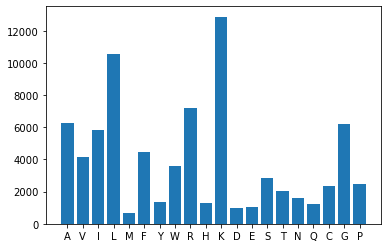

In [16]:
hemolytic_seq_list = dbaasp_hemolytic.Sequence.values.tolist()
hemolytic_aa_counts = AnalyzeComposition(hemolytic_seq_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

plt.bar(aa_labels, hemolytic_aa_counts)
plt.savefig('plots/barplots/hemolytic_aa_distribution.pdf')

DBAASP hemolytic: mean fractions and standard deviations of each amino acid

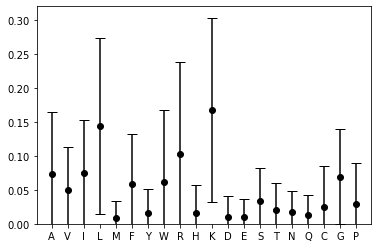

In [17]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))
hemolytic_mean, hemolytic_std = AnalyzeCompositionFraction(hemolytic_seq_list)

fig, ax = plt.subplots()
ax.errorbar(x_pos, hemolytic_mean, yerr=hemolytic_std, fmt='o', color='black', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/hemolytic_aafraction_distribution_stdev.pdf')

DBAASP not hemolytic

In [18]:
dbaasp_nonhemolytic = dbaasp_hemolysis[dbaasp_hemolysis['isNotHemolytic'] == 'Not Hemolytic'].copy()
dbaasp_nonhemolytic['Set'] = 'Not Hemolytic'
dbaasp_nonhemolytic = dbaasp_nonhemolytic[['Sequence', 'Set', 'Length']]

DBAASP not hemolytic: bar plot of total amino acid counts

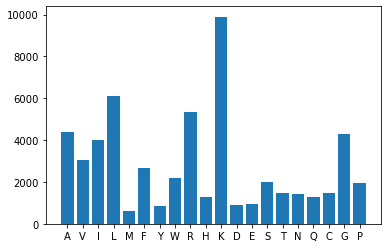

In [19]:
nonhemolytic_seq_list = dbaasp_nonhemolytic.Sequence.values.tolist()
nonhemolytic_aa_counts = AnalyzeComposition(nonhemolytic_seq_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

plt.bar(aa_labels, nonhemolytic_aa_counts)
plt.savefig('plots/barplots/nonhemolytic_aa_distribution.pdf')

DBAASP not hemolytic: mean fractions and standard deviations of each amino acid

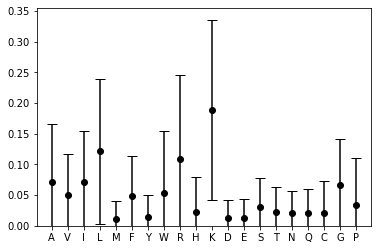

In [20]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))
nonhemolytic_mean, nonhemolytic_std = AnalyzeCompositionFraction(nonhemolytic_seq_list)

fig, ax = plt.subplots()
ax.errorbar(x_pos, nonhemolytic_mean, yerr=nonhemolytic_std, fmt='o', color='black', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/nonhemolytic_aafraction_distribution_stdev.pdf')

Import sequences selected with the RNN approach

In [21]:
rnn = pd.read_csv('data/anticancer_filtered.csv')
rnn['Length'] = rnn.Sequence.apply(Length)
rnn['Set'] = 'RNN'
rnn = rnn[['Sequence', 'Set', 'Length']]

RNN: bar plot of total amino acid counts

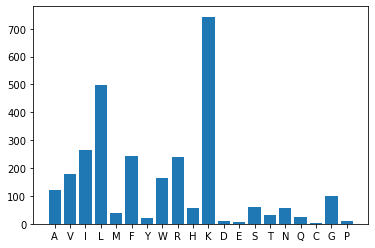

In [22]:
rnn_seq_list = rnn.Sequence.values.tolist()
rnn_aa_counts = AnalyzeComposition(rnn_seq_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

plt.bar(aa_labels, rnn_aa_counts)
plt.savefig('plots/barplots/rnn_aa_distribution.pdf')

RNN: mean fractions and standard deviations of each amino acid

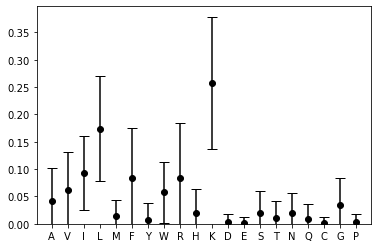

In [23]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))
rnn_mean, rnn_std = AnalyzeCompositionFraction(rnn_seq_list)

fig, ax = plt.subplots()
ax.errorbar(x_pos, rnn_mean, yerr=rnn_std, fmt='o', color='black', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/rnn_aafraction_distribution_stdev.pdf')

Import sequences selected with the PDGA approach

In [24]:
pdga = pd.read_csv('data/pdga_filtered.csv')
pdga['Length'] = pdga.Sequence.apply(Length)
pdga['Set'] = 'PDGA'
pdga = pdga[['Sequence', 'Set', 'Length']]

PDGA: bar plot of total amino acid counts

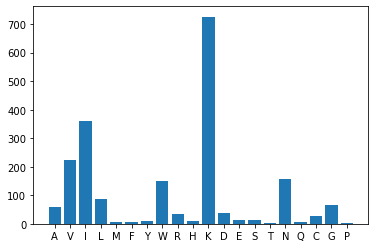

In [25]:
pdga_seq_list = pdga.Sequence.values.tolist()
pdga_aa_counts = AnalyzeComposition(pdga_seq_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

plt.bar(aa_labels, pdga_aa_counts)
plt.savefig('plots/barplots/pdga_aa_distribution.pdf')

PDGA: mean fractions and standard deviations of each amino acid

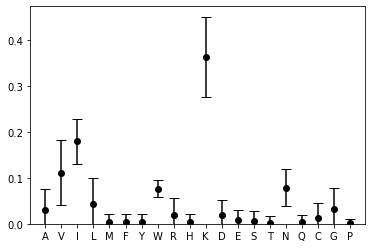

In [26]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))
pdga_mean, pdga_std = AnalyzeCompositionFraction(pdga_seq_list)

fig, ax = plt.subplots()
ax.errorbar(x_pos, pdga_mean, yerr=pdga_std, fmt='o', color='black', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/pdga_aafraction_distribution_stdev.pdf')

#### DBAASP amino acid distribution analysis and generation of random sequences matching the distribution of DBAASP

Normalize amino acid counts from dbaasp to obtain weights for random peptide generation

In [27]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
float_weights = (dbaasp_aa_counts/np.sum(dbaasp_aa_counts))*1000
int_weights = float_weights.astype(int)

labeled_weights = list(zip(aa_labels, int_weights))
weighted_population = [aa for aa, wt in labeled_weights for i in range(wt)]

Generate random set and save as .csv. If already run once, the cell will just load the previously generated set contained in the .csv file

In [28]:
if not os.path.exists('data/weighted_random_peptides_5_25.csv'):
    
    random_sequences = [RangeRandomSequence(weighted_population, 5, 25) for i in range(20000)]
    wtrandom = pd.DataFrame(random_sequences, columns=['Sequence'])
    wtrandom['Set'] = 'Random'
    wtrandom['Length'] = wtrandom.Sequence.apply(Length)
    wtrandom.to_csv('data/weighted_random_peptides_5_25.csv', index=False)

else:

    wtrandom = pd.read_csv('data/weighted_random_peptides_5_25.csv')

Random: bar plot of total amino acid counts

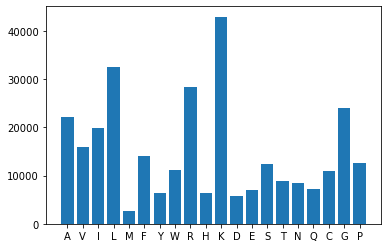

In [29]:
random_seq_list = wtrandom.Sequence.values.tolist()
random_aa_counts = AnalyzeComposition(random_seq_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

plt.bar(aa_labels, random_aa_counts)
plt.savefig('plots/barplots/random_aa_distribution.pdf')

Random: mean fractions and standard deviations of each amino acid

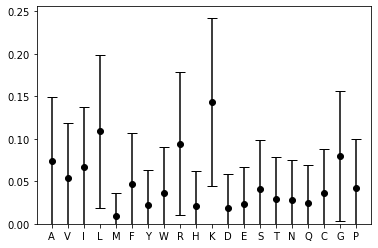

In [30]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))
random_mean, random_std = AnalyzeCompositionFraction(random_seq_list)

fig, ax = plt.subplots()
ax.errorbar(x_pos, random_mean, yerr=random_std, fmt='o', color='black', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/random_aafraction_distribution_stdev.pdf')

#### Mixed plots of fractions and standard deviations of amino acids

Mixed DBAASP and random

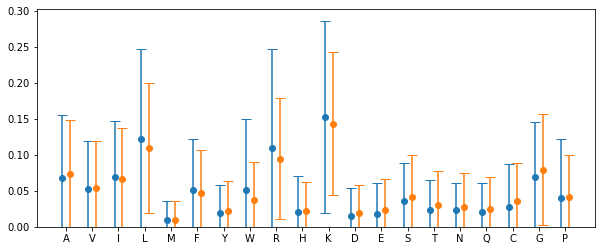

In [31]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))

fig, ax = plt.subplots(figsize=(10,4))
ax.errorbar(x_pos-0.15, dbaasp_mean, yerr=dbaasp_std, fmt='o', capsize=5)
ax.errorbar(x_pos+0.15, random_mean, yerr=random_std, fmt='o', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/mixed_aafraction_distribution_stdev.pdf')

Mixed RNN and PDGA

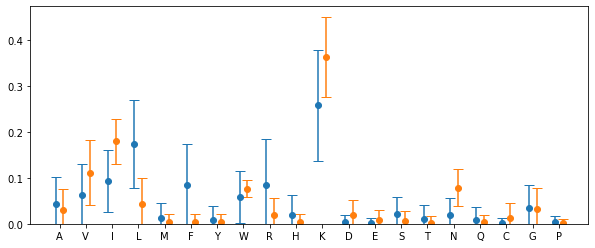

In [32]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))

fig, ax = plt.subplots(figsize=(10,4))
ax.errorbar(x_pos-0.15, rnn_mean, yerr=rnn_std, fmt='o', capsize=5)
ax.errorbar(x_pos+0.15, pdga_mean, yerr=pdga_std, fmt='o', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/mixed_sets_aafraction_distribution_stdev.pdf')

Mixed DBAASP actives and inactives

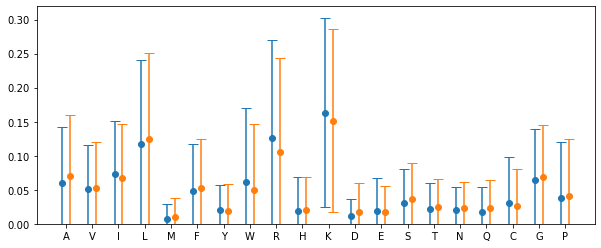

In [33]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))

fig, ax = plt.subplots(figsize=(10,4))
ax.errorbar(x_pos-0.15, actives_mean, yerr=actives_std, fmt='o', capsize=5)
ax.errorbar(x_pos+0.15, inactives_mean, yerr=inactives_std, fmt='o', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/mixed_act_aafraction_distribution_stdev.pdf')

Mixed DBAASP hemolytic and not hemolytic

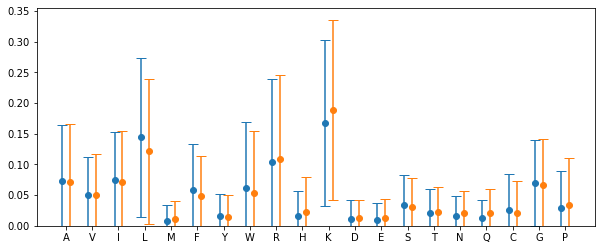

In [34]:
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))

fig, ax = plt.subplots(figsize=(10,4))
ax.errorbar(x_pos-0.15, hemolytic_mean, yerr=hemolytic_std, fmt='o', capsize=5)
ax.errorbar(x_pos+0.15, nonhemolytic_mean, yerr=nonhemolytic_std, fmt='o', capsize=5)
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)

plt.savefig('plots/barplots/mixed_hem_aafraction_distribution_stdev.pdf')

#### Lasioglossin III random mutator set

In [82]:
lasioglossin = 'VNWKKILGKIIKVVK'

In [83]:
def SequenceRandomMutator(sequence, p_mutation=0.5, p_insertion=0.25, p_deletion=0.25):

    mutated_sequence = sequence

    aa_list = ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

    mutation = randint(1, 10)/10
    insertion = randint(1, 10)/10
    deletion = randint(1, 10)/10

    mutations = randint(1, 7)
    insertions = randint(1, 5)
    deletions = randint(1, 5)

    if mutation >= p_mutation:
        for i in range(mutations):
            pos = randint(0, len(mutated_sequence))
            mutated_sequence = mutated_sequence[:pos-1] + choice(aa_list) + mutated_sequence[pos:]
    
    if insertion >= p_insertion:
        for i in range(insertions):
            pos = randint(0, len(mutated_sequence))
            mutated_sequence = mutated_sequence[:pos] + choice(aa_list) + mutated_sequence[pos:]

    if deletion >= p_deletion:
        for i in range(deletions):
            pos = randint(1, len(mutated_sequence))
            mutated_sequence = mutated_sequence[:pos-1] + mutated_sequence[pos:]

    return mutated_sequence

In [84]:
def isActiveAndNotHemolytic(row):

    if row.isPredActive == True and row.isPredNotHemolytic == True:
        return True
    else:
        return False

In [85]:
model_activity = Classifier.load_from_file('models/em100_hi400_la2_ep38')
model_hemolysis = Classifier.load_from_file('models/em100_hi400_la1_ep95')
model_activity.to('cpu')
model_hemolysis.to('cpu')

if not os.path.exists('data/lasioglossin_mutations.csv'):

    lasioglossin_mutations = [SequenceRandomMutator(lasioglossin) for i in range(100000)]
    lasioglossin_mutations_levenshtein = [Levenshtein.distance(lasioglossin, mutant) for mutant in lasioglossin_mutations]

    df_lasioglossin = pd.DataFrame(list(zip(lasioglossin_mutations, lasioglossin_mutations_levenshtein)), columns=['Sequence', 'Levenshtein'])
    df_lasioglossin = df_lasioglossin.drop_duplicates()

    df_lasioglossin['PredActivity'] = df_lasioglossin.Sequence.map(lambda x: model_activity.predict_peptide_sequence(x)[:,1][0])
    df_lasioglossin['isPredActive'] = df_lasioglossin['PredActivity'] > 0.99205756
    df_lasioglossin['PredHemolysis'] = df_lasioglossin.Sequence.map(lambda x: model_hemolysis.predict_peptide_sequence(x)[:,1][0])
    df_lasioglossin['isPredNotHemolytic'] = df_lasioglossin['PredHemolysis'] > 0.99981695
    df_lasioglossin['isActiveAndNotHemolytic'] = df_lasioglossin.apply(isActiveAndNotHemolytic, axis=1)
    df_lasioglossin.to_csv('data/lasioglossin_mutations.csv', sep='\t')

else:

    df_lasioglossin = pd.read_csv('data/lasioglossin_mutations.csv', sep='\t')

Calculate percentage of lasioglossin mutants predicted to be active and not hemolytic

In [86]:
len(df_lasioglossin[df_lasioglossin['isActiveAndNotHemolytic'] == True])/len(df_lasioglossin)*100

0.9004585978732663

Keep only sequences predicted to be active and not hemolytic

In [87]:
lasioglossin_selection = df_lasioglossin[df_lasioglossin['isActiveAndNotHemolytic'] == True]

Predict helicity of selected lasioglossin mutants

In [88]:
for idx, seq in enumerate(lasioglossin_selection.Sequence.values.tolist()):
    with open(f'/home/markus/Developer/SPIDER3-Single_np/lasioglossin/seq/Seq_{idx}.seq', 'w') as f:
        f.write(f'>Seq_{idx}')
        f.write('\n')
        f.write(f'{seq}')

    with open(f'/home/markus/Developer/SPIDER3-Single_np/lasioglossin_list', 'a') as f:
        f.write(f'Seq_{idx} ./anticancer_violin/seq/Seq_{idx}.seq')
        f.write('\n')

Helper functions to read SPIDER3 predictions

In [89]:
def read_spider(row:pd.DataFrame, folder:str) -> object:

    ss = []
    idx = str(row.name)
    name = f'Seq_{idx}.i1'

    with open(folder+name) as infile:
        for line in infile:
            line = line.strip()
            line = line.split(" ")
            ss.append(line[2])
    return ss[1:]


def count_ss(ss:object, pred:str='H') -> int:
    return ss.count(pred)


def fract_ss(ss:object, pred:str='H') -> float:
    if len(ss)!=0:
        return ss.count(pred)/len(ss)
    else:
        return 0

In [90]:
lasioglossin_selection = lasioglossin_selection.reset_index(drop=True)
lasioglossin_selection["SS"] = lasioglossin_selection.apply(lambda x: read_spider(x, '/home/markus/Developer/SPIDER3-Single_np/lasioglossin/out/'), axis=1)
lasioglossin_selection["countH"] = lasioglossin_selection.SS.map(count_ss)
lasioglossin_selection["fraction_PredHelical"] = lasioglossin_selection.SS.map(fract_ss)
lasioglossin_selection["fraction_PredBetaSheet"] = lasioglossin_selection.SS.map(lambda x : fract_ss(x, "E"))
lasioglossin_selection["fraction_PredCoil"] = lasioglossin_selection.SS.map(lambda x : fract_ss(x, "C"))

Hydrophobic moment

Functions copied from reference given in the annotation

In [91]:
"""
Calculates a set of properties from a protein sequence:
    - hydrophobicity (according to a particular scale)
    - mean hydrophobic dipole moment assuming it is an alpha-helix.
    - total charge (at pH 7.4)
    - amino acid composition
    - discimination factor according to Rob Keller (IJMS, 2011)
Essentially the same as HeliQuest (reproduces the same values).
Author:
  Joao Rodrigues
  j.p.g.l.m.rodrigues@gmail.com
"""

from __future__ import print_function

import argparse
import csv
import math
import os
import time

#
# Definitions
#
scales = {'Fauchere-Pliska': {'A':  0.31, 'R': -1.01, 'N': -0.60,
                              'D': -0.77, 'C':  1.54, 'Q': -0.22,
                              'E': -0.64, 'G':  0.00, 'H':  0.13,
                              'I':  1.80, 'L':  1.70, 'K': -0.99,
                              'M':  1.23, 'F':  1.79, 'P':  0.72,
                              'S': -0.04, 'T':  0.26, 'W':  2.25,
                              'Y':  0.96, 'V':  1.22},

          'Eisenberg': {'A':  0.25, 'R': -1.80, 'N': -0.64,
                        'D': -0.72, 'C':  0.04, 'Q': -0.69,
                        'E': -0.62, 'G':  0.16, 'H': -0.40,
                        'I':  0.73, 'L':  0.53, 'K': -1.10,
                        'M':  0.26, 'F':  0.61, 'P': -0.07,
                        'S': -0.26, 'T': -0.18, 'W':  0.37,
                        'Y':  0.02, 'V':  0.54},
          }
_supported_scales = list(scales.keys())

aa_charge = {'E': -1, 'D': -1, 'K': 1, 'R': 1}

#
# Functions
#
def assign_hydrophobicity(sequence, scale='Fauchere-Pliska'):  # noqa: E302
    """Assigns a hydrophobicity value to each amino acid in the sequence"""

    hscale = scales.get(scale, None)
    if not hscale:
        raise KeyError('{} is not a supported scale. '.format(scale))

    hvalues = []
    for aa in sequence:
        sc_hydrophobicity = hscale.get(aa, None)
        if sc_hydrophobicity is None:
            raise KeyError('Amino acid not defined in scale: {}'.format(aa))
        hvalues.append(sc_hydrophobicity)

    return hvalues


def calculate_moment(array, angle=100):
    """Calculates the hydrophobic dipole moment from an array of hydrophobicity
    values. Formula defined by Eisenberg, 1982 (Nature). Returns the average
    moment (normalized by sequence length)
    uH = sqrt(sum(Hi cos(i*d))**2 + sum(Hi sin(i*d))**2),
    where i is the amino acid index and d (delta) is an angular value in
    degrees (100 for alpha-helix, 180 for beta-sheet).
    """

    sum_cos, sum_sin = 0.0, 0.0
    for i, hv in enumerate(array):
        rad_inc = ((i*angle)*math.pi)/180.0
        sum_cos += hv * math.cos(rad_inc)
        sum_sin += hv * math.sin(rad_inc)
    if len(array) != 0:
        return math.sqrt(sum_cos**2 + sum_sin**2) / len(array)
    else:
        print(array)
        return 0


def calculate_charge(sequence, charge_dict=aa_charge):
    """Calculates the charge of the peptide sequence at pH 7.4
    """
    sc_charges = [charge_dict.get(aa, 0) for aa in sequence]
    return sum(sc_charges)


def calculate_discrimination(mean_uH, total_charge):
    """Returns a discrimination factor according to Rob Keller (IJMS, 2011)
    A sequence with d>0.68 can be considered a potential lipid-binding region.
    """
    d = 0.944*mean_uH + 0.33*total_charge
    return d


def calculate_composition(sequence):
    """Returns a dictionary with percentages per classes"""

    # Residue character table
    polar_aa = set(('S', 'T', 'N', 'H', 'Q', 'G'))
    speci_aa = set(('P', 'C'))
    apolar_aa = set(('A', 'L', 'V', 'I', 'M'))
    charged_aa = set(('E', 'D', 'K', 'R'))
    aromatic_aa = set(('W', 'Y', 'F'))

    n_p, n_s, n_a, n_ar, n_c = 0, 0, 0, 0, 0
    for aa in sequence:
        if aa in polar_aa:
            n_p += 1
        elif aa in speci_aa:
            n_s += 1
        elif aa in apolar_aa:
            n_a += 1
        elif aa in charged_aa:
            n_c += 1
        elif aa in aromatic_aa:
            n_ar += 1

    return {'polar': n_p, 'special': n_s,
            'apolar': n_a, 'charged': n_c, 'aromatic': n_ar}


def analyze_sequence(name=None, sequence=None, window=18, verbose=False):
    """Runs all the above on a sequence. Pretty prints the results"""



    w = window

    outdata = []  # for csv writing

    # Processing...
    seq_len = len(sequence)
    print('[+] Analysing sequence {} ({} aa.)'.format(name, seq_len))
    print('[+] Using a window of {} aa.'.format(w))
    for seq_range in range(0, seq_len):

        seq_w = sequence[seq_range:seq_range+w]
        if seq_range and len(seq_w) < w:
            break

        # Numerical values
        z = calculate_charge(seq_w)
        seq_h = assign_hydrophobicity(seq_w)
        av_h = sum(seq_h)/len(seq_h)
        av_uH = calculate_moment(seq_h)
        d = calculate_discrimination(av_uH, z)

        # AA composition
        aa_comp = calculate_composition(seq_w)
        n_tot_pol = aa_comp['polar'] + aa_comp['charged']
        n_tot_apol = aa_comp['apolar'] + aa_comp['aromatic'] + aa_comp['special']  # noqa: E501
        n_charged = aa_comp['charged']  # noqa: E501
        n_aromatic = aa_comp['aromatic']  # noqa: E501

        _t = [name, sequence, seq_range+1, w, seq_w, z, av_h, av_uH, d,
              n_tot_pol, n_tot_apol, n_charged, n_aromatic]
        outdata.append(_t)

        if verbose:
            print('  Window {}: {}-{}-{}'.format(seq_range+1, seq_range,
                                                 seq_w, seq_range+w))
            print('    z={:<3d} <H>={:4.3f} <uH>={:4.3f} D={:4.3f}'.format(z, av_h,  # noqa: E501
                                                                           av_uH, d))  # noqa: E501
            print('    Amino acid composition')
            print('      Polar    : {:3d} / {:3.2f}%'.format(n_tot_pol, n_tot_pol*100/w))  # noqa: E501
            print('      Non-Polar: {:3d} / {:3.2f}%'.format(n_tot_apol, n_tot_apol*100/w))  # noqa: E501
            print('      Charged  : {:3d} / {:3.2f}%'.format(n_charged, n_charged*100/w))  # noqa: E501
            print('      Aromatic : {:3d} / {:3.2f}%'.format(n_aromatic, n_aromatic*100/w))  # noqa: E501
            print()

    return outdata


def read_fasta_file(afile):
    """Parses a file with FASTA formatted sequences"""

    if not os.path.isfile(afile):
        raise IOError('File not found/readable: {}'.format(afile))

    sequences = []
    seq_name, cur_seq = None, None
    with open(afile) as handle:
        for line in handle:
            line = line.strip()
            if line.startswith('>'):
                if cur_seq:
                    sequences.append((seq_name, ''.join(cur_seq)))
                seq_name = line[1:]
                cur_seq = []
            elif line:
                cur_seq.append(line)
    sequences.append((seq_name, ''.join(cur_seq)))  # last seq

    return sequences

def hydr_moment(seq):
    seq = seq.upper()
    hdr = assign_hydrophobicity(seq,"Eisenberg")
    return calculate_moment(hdr)

In [45]:
lasioglossin_selection['HydroMoment'] = lasioglossin_selection.Sequence.apply(hydr_moment)

Plot distributions of Levenshtein distance towards Lasioglossin III, helicity and hydrophobic moment

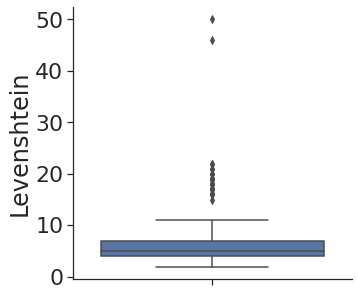

In [92]:
ax = sns.boxplot(y='Levenshtein', data=lasioglossin_selection)
sns.set(rc={'figure.figsize':(5, 5)})
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_lasioglossin_levenshtein.pdf', bbox_inches='tight')

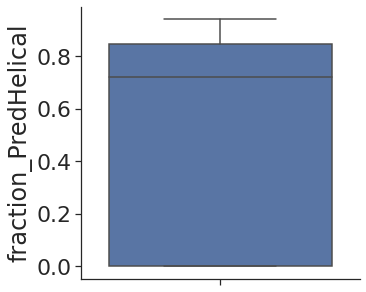

In [80]:
ax = sns.boxplot(y='fraction_PredHelical', data=lasioglossin_selection)
sns.set(rc={'figure.figsize':(5, 5)})
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_lasioglossin_helicity.pdf', bbox_inches='tight')

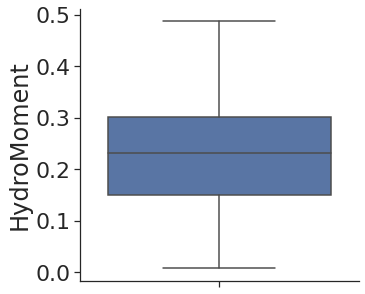

In [81]:
ax = sns.boxplot(y='HydroMoment', data=lasioglossin_selection)
sns.set(rc={'figure.figsize':(5, 5)})
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_lasioglossin_hydromoment.pdf', bbox_inches='tight')

Check how many sequences would pass all selection filters

In [49]:
lasioglossin_selection[(lasioglossin_selection.Levenshtein.between(6, 7)) & (lasioglossin_selection.fraction_PredHelical >= 0.83) & (lasioglossin_selection.HydroMoment >= 0.31)]

,Unnamed: 0,Sequence,Levenshtein,PredActivity,isPredActive,PredHemolysis,isPredNotHemolytic,isActiveAndNotHemolytic,SS,countH,fraction_PredHelical,fraction_PredBetaSheet,fraction_PredCoil,HydroMoment
27,2983,VNGKWKIIKVVKK,6,0.995347,True,1.000000,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",16,0.888889,0.0,0.111111,0.310533
35,3592,VWKKIGKIIGDVKNS,6,0.999099,True,1.000000,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",20,0.869565,0.0,0.130435,0.378929
45,4294,RVNNWCKKILKIIDVK,6,0.999261,True,1.000000,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",18,0.900000,0.0,0.100000,0.315018
128,14484,VNWHKILRKIGV,6,0.992059,True,0.999906,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",23,0.884615,0.0,0.115385,0.329667
181,19121,DVNVWKKIKCIIRKLVK,7,0.999613,True,1.000000,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",18,0.857143,0.0,0.142857,0.399899
263,28251,VKNWKKQGKINCKIVK,6,0.999503,True,0.999982,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, C]",12,0.857143,0.0,0.142857,0.330596
302,34027,GVWPNWKNICGKIGKVVK,6,0.992442,True,0.999999,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",22,0.880000,0.0,0.120000,0.319958
304,34408,VNNEWKKIIQKIINVHVK,6,0.994380,True,0.999998,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",22,0.880000,0.0,0.120000,0.341353
310,34746,VWKKIRYLGKISVK,6,0.995997,True,0.999998,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",22,0.880000,0.0,0.120000,0.367406
364,40936,VNWKKICKIF,7,0.999061,True,0.999998,True,True,"[C, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...",32,0.941176,0.0,0.058824,0.334417


#### Concatenate all the dataframes

In [50]:
df = pd.concat([dbaasp, wtrandom, dbaasp_actives, dbaasp_inactives, dbaasp_nonhemolytic, dbaasp_hemolytic, rnn, pdga], ignore_index=True)

#### Helicity prediction with SPIDER3

Generate sequence input files and list of pointers towards the sequence files. These will be used by SPIDER3 for the helicity predictiona. Run cell once, otherwise the output in the list of pointers will be doubled and it will mess up the helicity prediction.

In [51]:
for idx, seq in enumerate(df.Sequence.values.tolist()):
    with open(f'/home/markus/Developer/SPIDER3-Single_np/anticancer_violin/seq/Seq_{idx}.seq', 'w') as f:
        f.write(f'>Seq_{idx}')
        f.write('\n')
        f.write(f'{seq}')

    with open(f'/home/markus/Developer/SPIDER3-Single_np/anticancer_violin_list', 'a') as f:
        f.write(f'Seq_{idx} ./anticancer_violin/seq/Seq_{idx}.seq')
        f.write('\n')

Add predicted helicity to dataframe

In [52]:
df["SS"] = df.apply(lambda x: read_spider(x, '/home/markus/Developer/SPIDER3-Single_np/anticancer_violin/out/'), axis=1)
df["countH"] = df.SS.map(count_ss)
df["fraction_PredHelical"] = df.SS.map(fract_ss)
df["fraction_PredBetaSheet"] = df.SS.map(lambda x : fract_ss(x, "E"))
df["fraction_PredCoil"] = df.SS.map(lambda x : fract_ss(x, "C"))

#### Calculate hydrophobic moment

In [53]:
df['HydroMoment'] = df.Sequence.apply(hydr_moment)

#### Calculate fraction of positive charges

In [54]:
def frac_pos_charges(seq:str) -> float: 
    """
    Determine the fraction of positive charges in a sequence. 
    """
    counter_pos = seq.count('K') + seq.count('R')
    return counter_pos/len(seq)

In [55]:
df['fraction_PosCharges'] = df.Sequence.apply(frac_pos_charges)

#### Violin plots

Prepare dataframes for violin plots

In [56]:
#Set figure size
sns.set(rc={'figure.figsize':(16, 8)})

#Dataframe subsets
wtrandom = df[df['Set'] == 'Random'].copy()
wtrandom = wtrandom.drop_duplicates(subset=['Sequence']).copy()

dbaasp = df[df['Set'] == 'DBAASP'].copy()
dbaasp = dbaasp.drop_duplicates(subset=['Sequence']).copy()

rnn = df[df['Set'] == 'RNN'].copy()
rnn = rnn.drop_duplicates(subset=['Sequence']).copy()

pdga = df[df['Set'] == 'PDGA'].copy()
pdga = pdga.drop_duplicates(subset=['Sequence']).copy()

dbaasp_actives = df[df['Set'] == 'Active'].copy()
dbaasp_actives = dbaasp_actives.drop_duplicates(subset=['Sequence']).copy()

dbaasp_inactives = df[df['Set'] == 'Inactive'].copy()
dbaasp_inactives = dbaasp_inactives.drop_duplicates(subset=['Sequence']).copy()

dbaasp_hemolytic = df[df['Set'] == 'Hemolytic'].copy()
dbaasp_hemolytic = dbaasp_hemolytic.drop_duplicates(subset=['Sequence']).copy()

dbaasp_nonhemolytic = df[df['Set'] == 'Not Hemolytic'].copy()
dbaasp_hemolytic = dbaasp_nonhemolytic.drop_duplicates(subset=['Sequence']).copy()

active_hemolytic = pd.merge(dbaasp_actives, dbaasp_hemolytic, how='inner', on=['Sequence', 'Length', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges'])
active_hemolytic = active_hemolytic[['Sequence', 'Length', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges']]
active_hemolytic['Set'] = 'Act. & hem.'

active_nonhemolytic = pd.merge(dbaasp_actives, dbaasp_nonhemolytic, how='inner', on=['Sequence', 'Length', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges'])
active_nonhemolytic = active_nonhemolytic[['Sequence', 'Length', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges']]
active_nonhemolytic['Set'] = 'Act. & not hem.'

inactive_hemolytic = pd.merge(dbaasp_inactives, dbaasp_hemolytic, how='inner', on=['Sequence', 'Length', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges'])
inactive_hemolytic = inactive_hemolytic[['Sequence', 'Length', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges']]
inactive_hemolytic['Set'] = 'Inact. & hem.'

inactive_nonhemolytic = pd.merge(dbaasp_inactives, dbaasp_nonhemolytic, how='inner', on=['Sequence', 'Length', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges'])
inactive_nonhemolytic = inactive_nonhemolytic[['Sequence', 'Length', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges']]
inactive_nonhemolytic['Set'] = 'Inact. & not hem.'

figure1 = pd.concat([wtrandom, dbaasp, rnn, pdga])
figure2 = pd.concat([active_hemolytic, active_nonhemolytic, inactive_hemolytic, inactive_nonhemolytic])

Mean, median and SD of active, inactive, hemolytic and nonhemolytic set

In [57]:
def StatisticalAnalysis(values:list) -> str:
    """
    Returns mean and std in the form of mean +- std
    """
    mean = sum(values)/len(values)
    variance = sum([((x - mean) ** 2) for x in values])/len(values)
    std = variance**0.5

    return f'{mean} ± {std}'

print('Predicted Helicity')
print(f'Actives: {StatisticalAnalysis(dbaasp_actives.fraction_PredHelical.values.tolist())}')
print(f'Inactives: {StatisticalAnalysis(dbaasp_inactives.fraction_PredHelical.values.tolist())}')
print(f'Hemolytic: {StatisticalAnalysis(dbaasp_hemolytic.fraction_PredHelical.values.tolist())}')
print(f'Not Hemolytic: {StatisticalAnalysis(dbaasp_nonhemolytic.fraction_PredHelical.values.tolist())}')
print('')

print('Hydrophobic Moment')
print(f'Actives: {StatisticalAnalysis(dbaasp_actives.HydroMoment.values.tolist())}')
print(f'Inactives: {StatisticalAnalysis(dbaasp_inactives.HydroMoment.values.tolist())}')
print(f'Hemolytic: {StatisticalAnalysis(dbaasp_hemolytic.HydroMoment.values.tolist())}')
print(f'Not Hemolytic: {StatisticalAnalysis(dbaasp_nonhemolytic.HydroMoment.values.tolist())}')
print('')

print('Fraction Positive Charges')
print(f'Actives: {StatisticalAnalysis(dbaasp_actives.fraction_PosCharges.values.tolist())}')
print(f'Inactives: {StatisticalAnalysis(dbaasp_inactives.fraction_PosCharges.values.tolist())}')
print(f'Hemolytic: {StatisticalAnalysis(dbaasp_hemolytic.fraction_PosCharges.values.tolist())}')
print(f'Not Hemolytic: {StatisticalAnalysis(dbaasp_nonhemolytic.fraction_PosCharges.values.tolist())}')
print('')

Predicted Helicity
Actives: 0.4694590026707218 ± 0.3806160233003963
Inactives: 0.44885067501224674 ± 0.369143133291634
Hemolytic: 0.4972728090760808 ± 0.3651373422646261
Not Hemolytic: 0.4931035989789418 ± 0.36657611108636645

Hydrophobic Moment
Actives: 0.2599476869936552 ± 0.15487111203180742
Inactives: 0.252677616776172 ± 0.14801282555132467
Hemolytic: 0.271104784918803 ± 0.1482545739284198
Not Hemolytic: 0.27476538620516616 ± 0.14961262326029753

Fraction Positive Charges
Actives: 0.28600519286767584 ± 0.1448569899912668
Inactives: 0.25280371990279327 ± 0.15313264646854277
Hemolytic: 0.29318968970755666 ± 0.1505335234280952
Not Hemolytic: 0.2975373986460475 ± 0.15226871686325005



Create subsets containing sequences only above 18 and sequences only below 18

In [362]:
figure1_below18 = figure1[figure1['Length'] <= 18] 
figure2_below18 = figure2[figure2['Length'] <= 18] 

figure1_above18 = figure1[figure1['Length'] > 18] 
figure2_above18 = figure2[figure2['Length'] > 18] 

Helicity

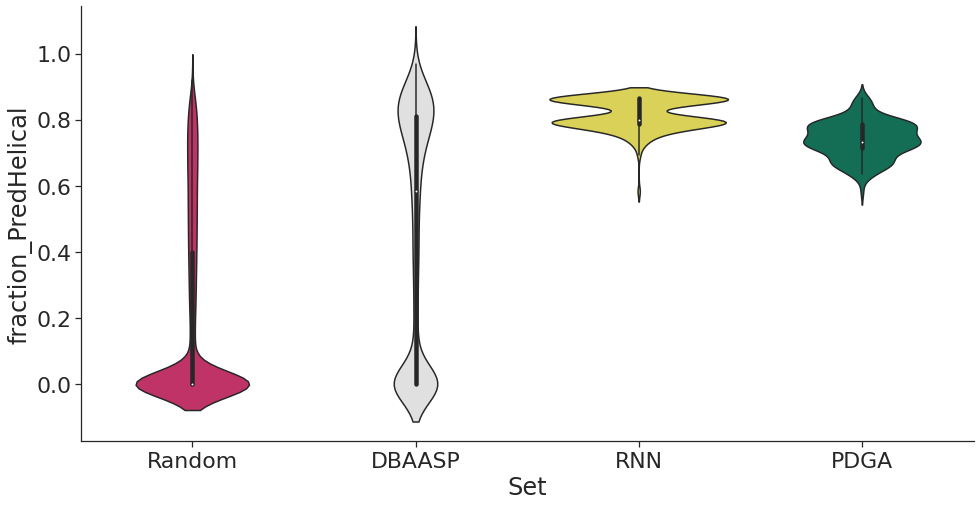

In [364]:
ax = sns.violinplot(x='Set', y='fraction_PredHelical', data=figure1, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_helicity_figure1.pdf', bbox_inches='tight')

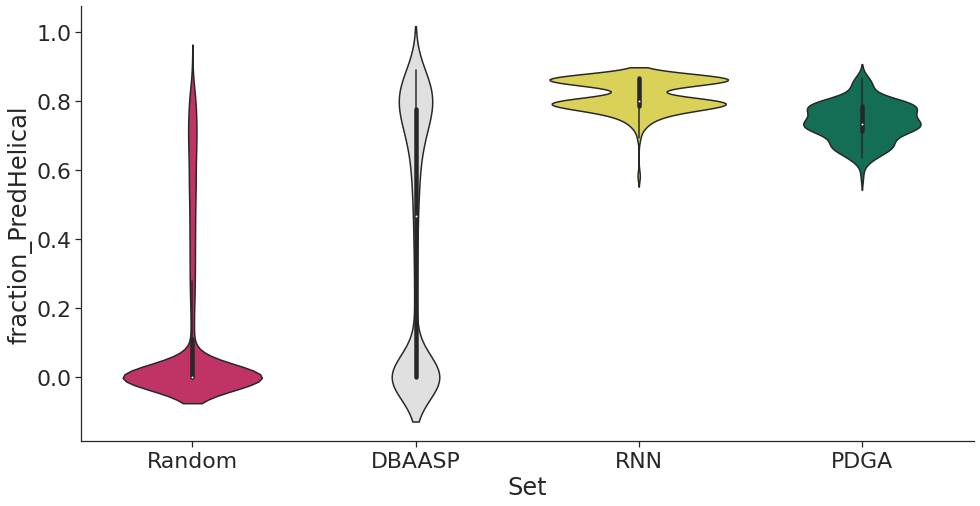

In [365]:
ax = sns.violinplot(x='Set', y='fraction_PredHelical', data=figure1_below18, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_helicity_figure1_below18.pdf', bbox_inches='tight')

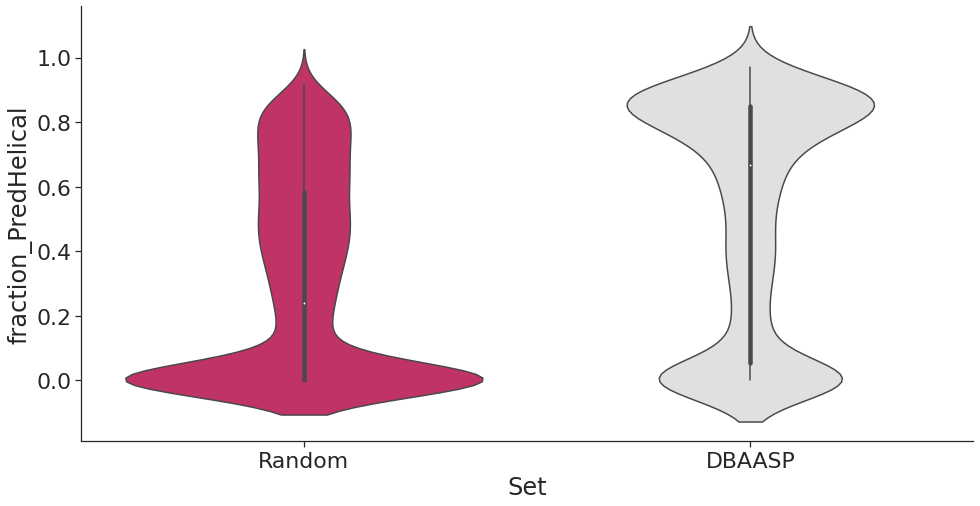

In [366]:
ax = sns.violinplot(x='Set', y='fraction_PredHelical', data=figure1_above18, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_helicity_figure1_above18.pdf', bbox_inches='tight')

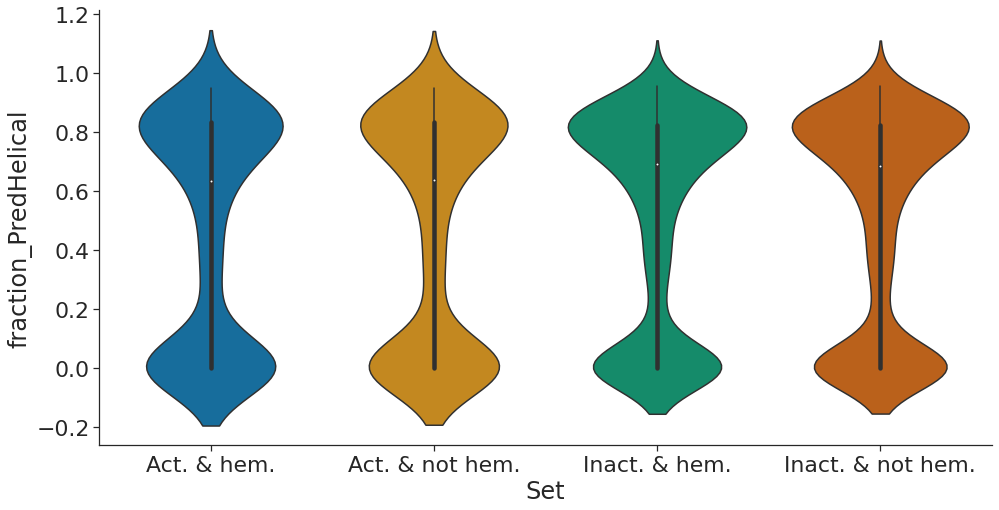

In [367]:
ax = sns.violinplot(x='Set', y='fraction_PredHelical', data=figure2, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_helicity_figure2.pdf', bbox_inches='tight')

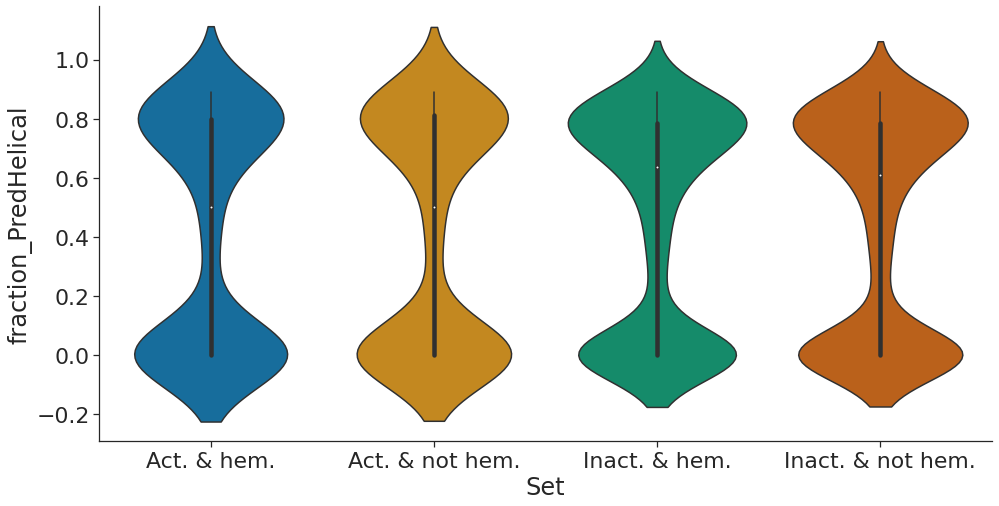

In [368]:
ax = sns.violinplot(x='Set', y='fraction_PredHelical', data=figure2_below18, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_helicity_figure2_below18.pdf', bbox_inches='tight')

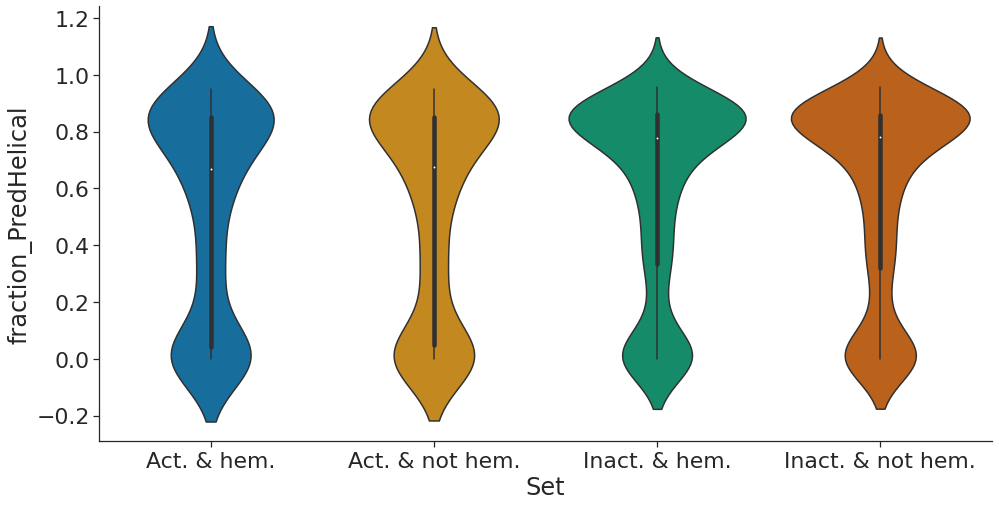

In [369]:
ax = sns.violinplot(x='Set', y='fraction_PredHelical', data=figure2_above18, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_helicity_figure2_above18.pdf', bbox_inches='tight')

Hydrophobic Moment

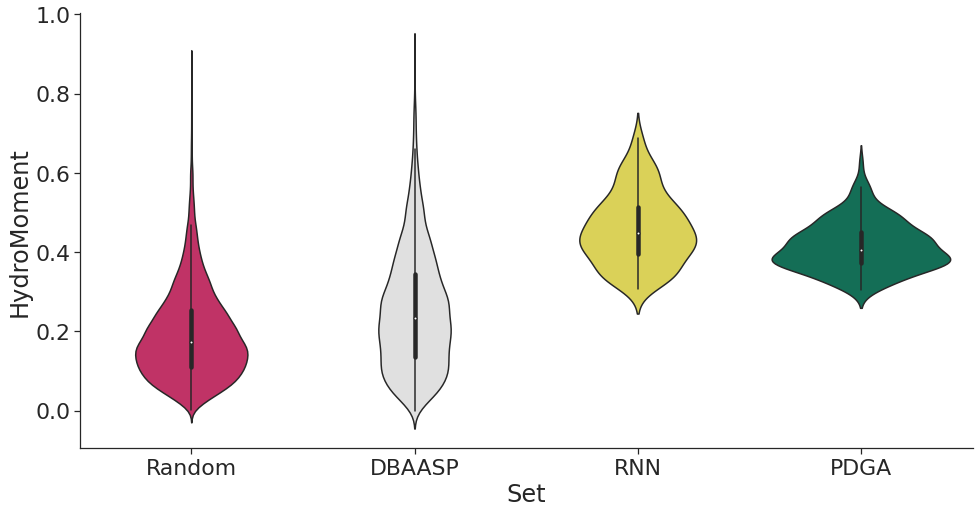

In [370]:
ax = sns.violinplot(x='Set', y='HydroMoment', data=figure1, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_hydromoment_figure1.pdf', bbox_inches='tight')

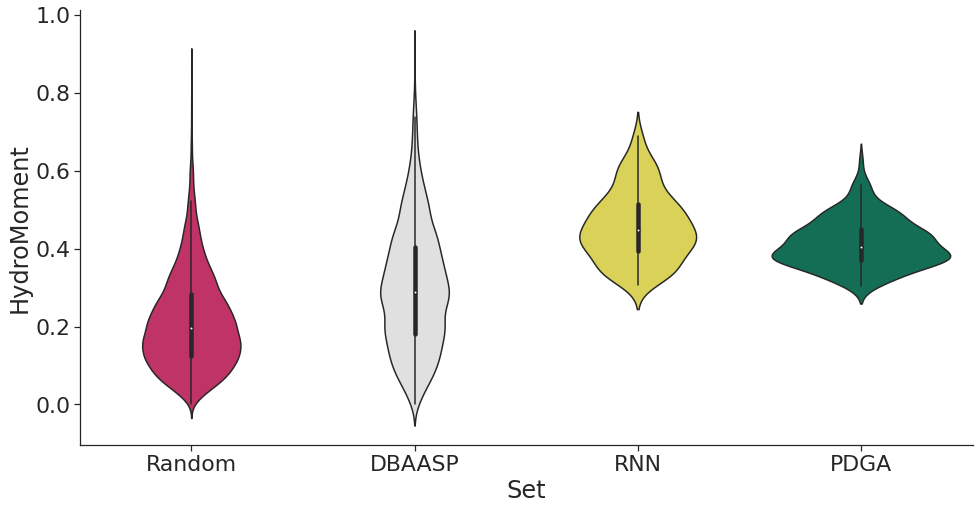

In [371]:
ax = sns.violinplot(x='Set', y='HydroMoment', data=figure1_below18, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_hydromoment_figure1_below18.pdf', bbox_inches='tight')

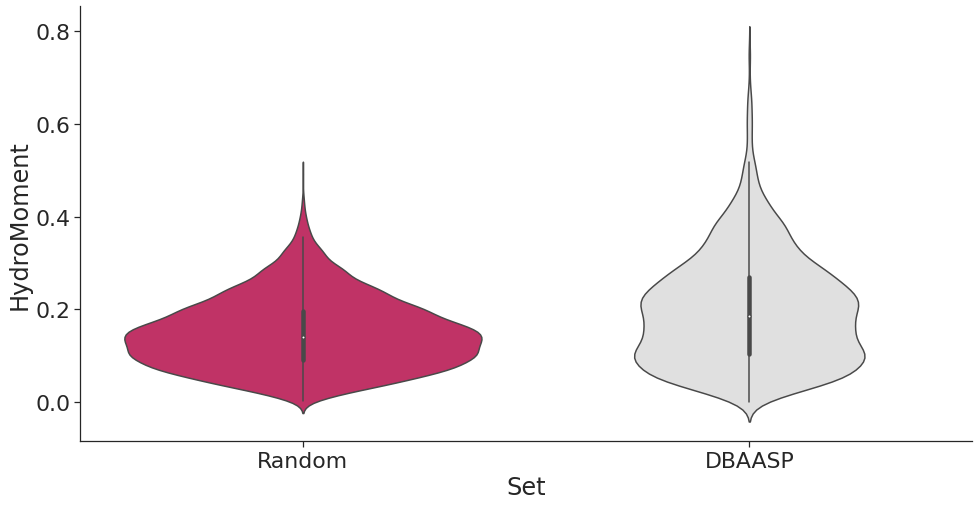

In [372]:
ax = sns.violinplot(x='Set', y='HydroMoment', data=figure1_above18, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_hydromoment_figure1_above18.pdf', bbox_inches='tight')

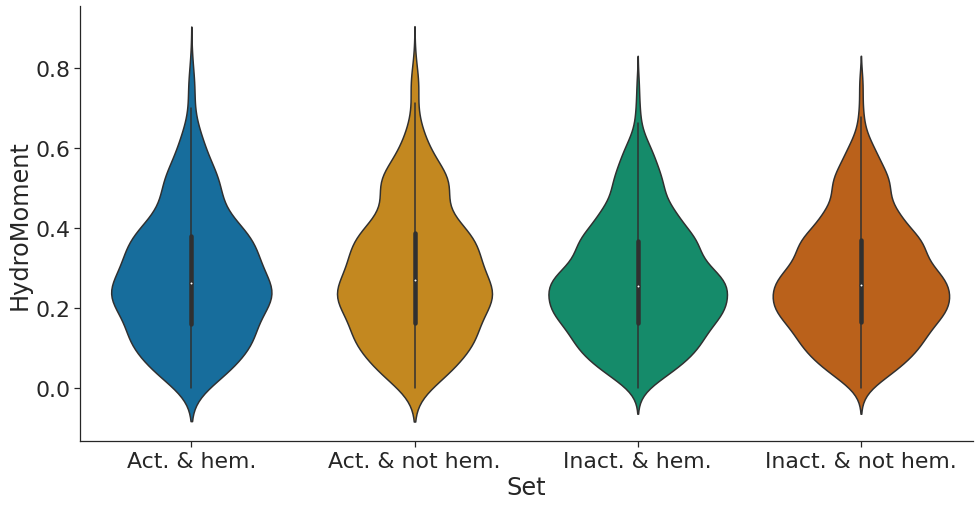

In [373]:
ax = sns.violinplot(x='Set', y='HydroMoment', data=figure2, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_hydromoment_figure2.pdf', bbox_inches='tight')

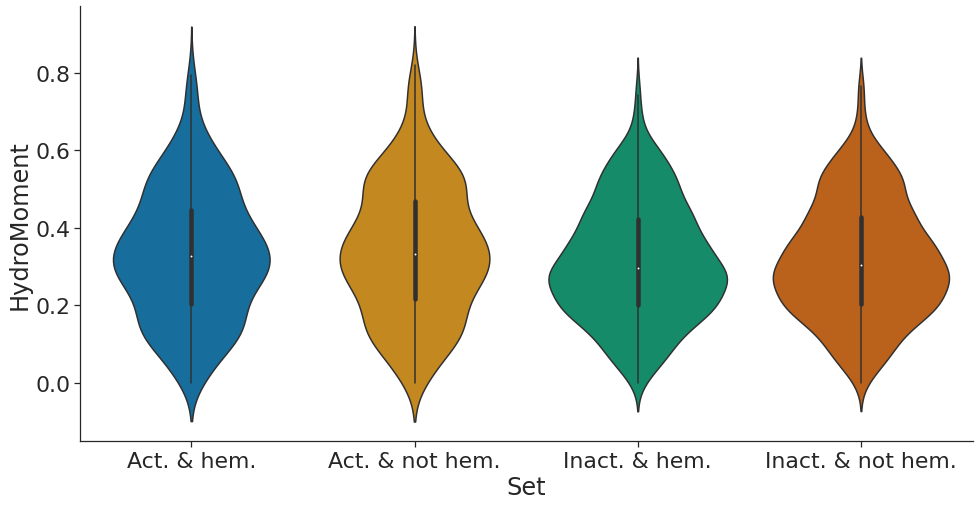

In [374]:
ax = sns.violinplot(x='Set', y='HydroMoment', data=figure2_below18, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_hydromoment_figure2_below18.pdf', bbox_inches='tight')

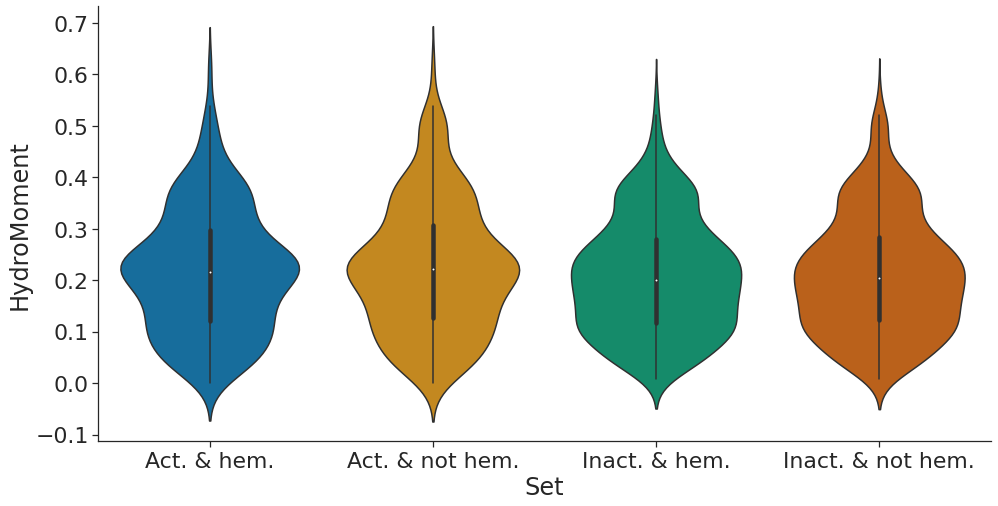

In [375]:
ax = sns.violinplot(x='Set', y='HydroMoment', data=figure2_above18, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_hydromoment_figure2_above18.pdf', bbox_inches='tight')

Fraction of positive charges

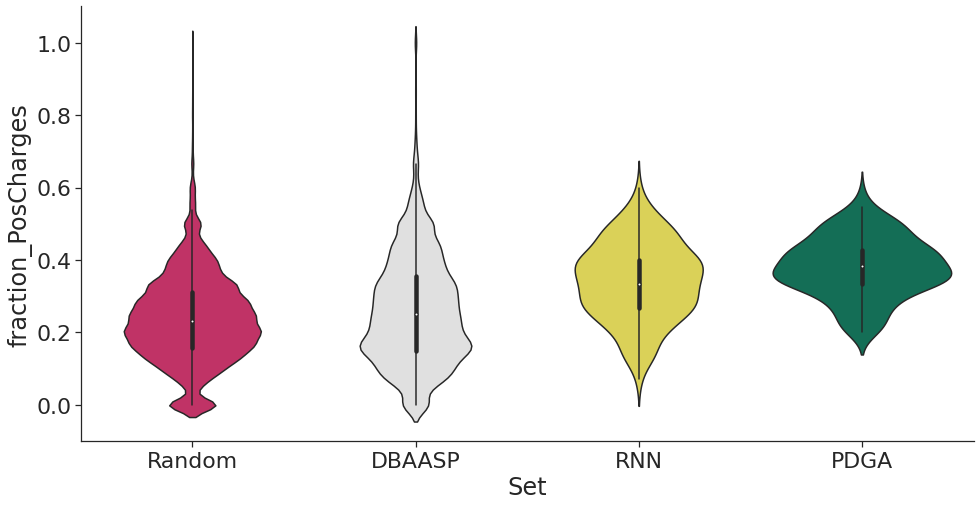

In [376]:
ax = sns.violinplot(x='Set', y='fraction_PosCharges', data=figure1, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_poscharges_figure1.pdf', bbox_inches='tight')

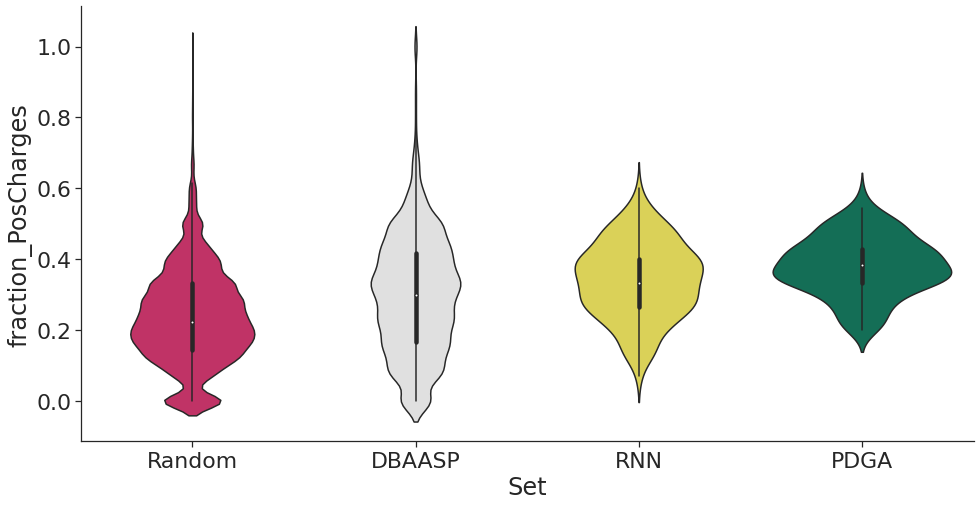

In [377]:
ax = sns.violinplot(x='Set', y='fraction_PosCharges', data=figure1_below18, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_poscharges_figure1_below18.pdf', bbox_inches='tight')

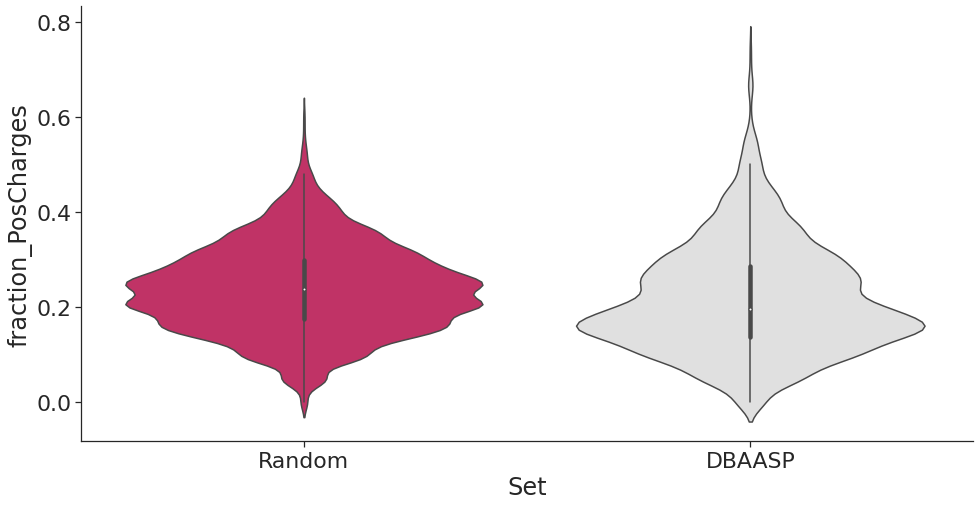

In [378]:
ax = sns.violinplot(x='Set', y='fraction_PosCharges', data=figure1_above18, palette=['#D81B60', '#E0E0E0', '#F0E442', '#057D5D'])
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_poscharges_figure1_above18.pdf', bbox_inches='tight')

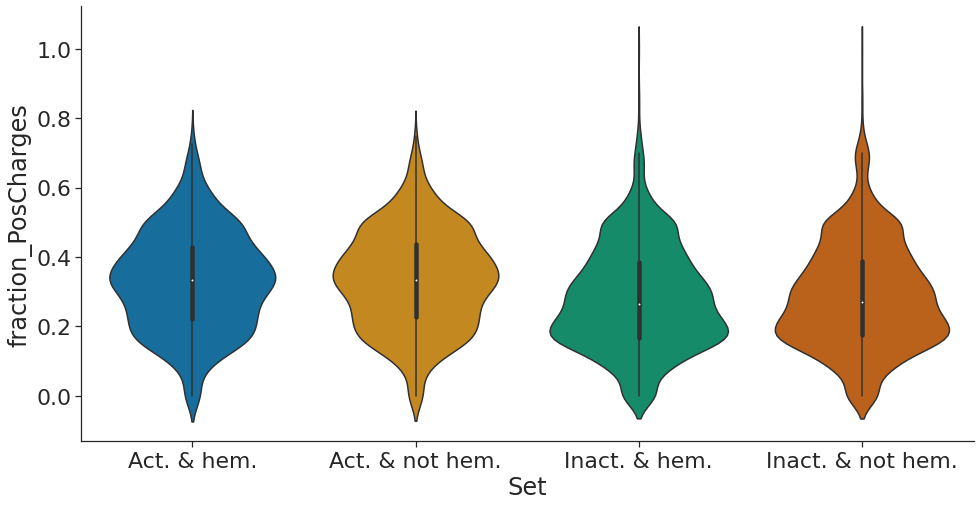

In [379]:
ax = sns.violinplot(x='Set', y='fraction_PosCharges', data=figure2, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_poscharges_figure2.pdf', bbox_inches='tight')

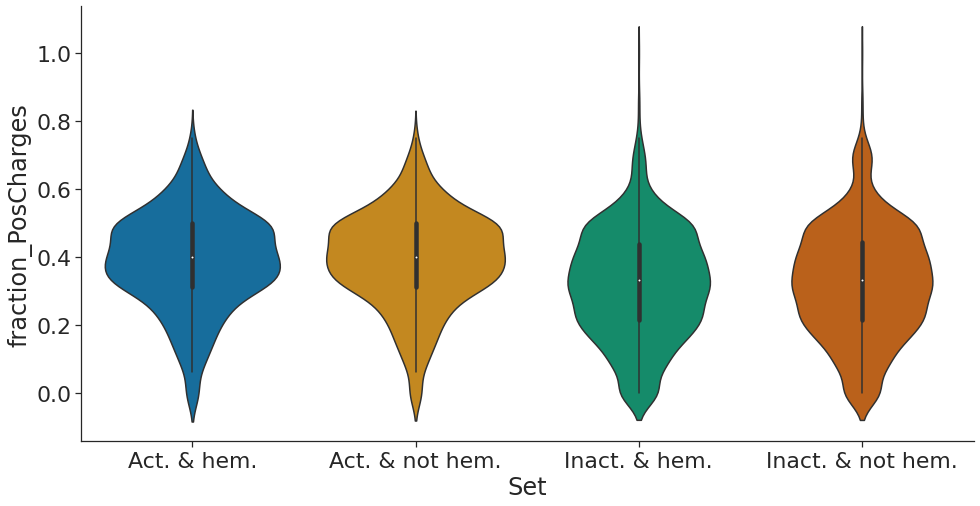

In [380]:
ax = sns.violinplot(x='Set', y='fraction_PosCharges', data=figure2_below18, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_poscharges_figure2_below18.pdf', bbox_inches='tight')

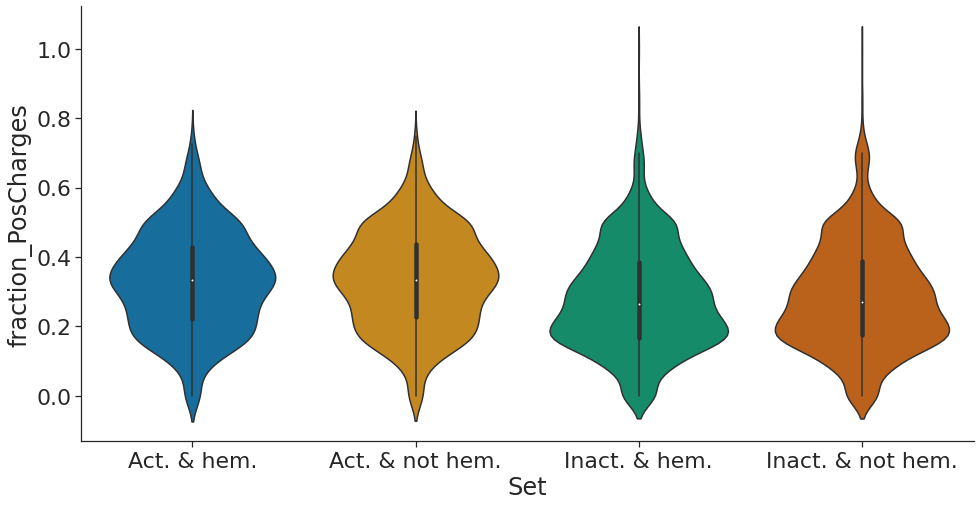

In [381]:
ax = sns.violinplot(x='Set', y='fraction_PosCharges', data=figure2, palette='colorblind')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/violin/violin_poscharges_figure2_above18.pdf', bbox_inches='tight')

#### MAP4 TMAP with activity and hemolysis prediction outcomes (true/false positive/negative)

Prepare the dataframe containing dbaasp, synthesized and selected compounds from both approaches and literature compounds

In [58]:
#DBAASP sequences with activity and hemolysis annotation
activity = dbaasp_activity.drop_duplicates(subset='Sequence').copy()
hemolysis = dbaasp_hemolysis.drop_duplicates(subset='Sequence').copy()

#Synthesized sequences
synthesized = pd.read_csv('data/synthesized_sequences.csv')

#Selected sequences from RNN and PDGA approaches
rnn['isActive'] = 'Unknown'
rnn['isNotHemolytic'] = 'Unknown'
rnn['Set'] = 'RNN selected'

pdga['isActive'] = 'Unknown'
pdga['isNotHemolytic'] = 'Unknown'
pdga['Set'] = 'PDGA selected'

selected = pd.concat([rnn, pdga])
selected = pd.merge(selected, synthesized, on=['Sequence'], how='outer', indicator=True)
selected = selected[selected['_merge']=='left_only']
selected = selected.rename(columns={'Set_x': 'Set', 'Length_x': 'Length', 'isActive_x': 'isActive', 'isNotHemolytic_x': 'isNotHemolytic'})
selected = selected[['Sequence', 'Set', 'Length', 'isActive', 'isNotHemolytic']]

#Literature sequences
literature = pd.read_csv('data/literature_sequences.csv')

#Merge dataframes
df_tmap = pd.merge(activity, hemolysis, how='inner', on=['ID', 'Sequence', 'Length'])
df_tmap['Set'] = 'DBAASP'
df_tmap = df_tmap[['Sequence', 'Set', 'Length', 'isActive', 'isNotHemolytic']]
df_tmap = df_tmap.append(selected)
df_tmap = df_tmap.append(synthesized)
df_tmap = df_tmap.append(literature)

Rename Set to order them in Faerun 

In [59]:
df_tmap.loc[df_tmap['Set'] == 'DBAASP', 'Set'] = '0 - DBAASP'
df_tmap.loc[df_tmap['Set'] == 'RNN selected', 'Set'] = '1 - RNN selected'
df_tmap.loc[df_tmap['Set'] == 'RNN synthesized', 'Set'] = '2 - RNN synthesized'
df_tmap.loc[df_tmap['Set'] == 'PDGA selected', 'Set'] = '3 - PDGA selected'
df_tmap.loc[df_tmap['Set'] == 'PDGA synthesized', 'Set'] = '4 - PDGA synthesized'
df_tmap.loc[df_tmap['Set'] == 'Literature', 'Set'] = '5 - Literature'

Load activity and hemolysis classifier and add predicted activity and hemolysis to dataframe. Determine the outcome of the prediction (true/false positive/negative)

In [60]:
model_activity = Classifier.load_from_file('models/em100_hi400_la2_ep38')
model_hemolysis = Classifier.load_from_file('models/em100_hi400_la1_ep95')

model_activity.to('cpu')
model_hemolysis.to('cpu')

df_tmap['PredActivity'] = df_tmap.Sequence.map(lambda x: model_activity.predict_peptide_sequence(x)[:,1][0])
df_tmap['isPredActive'] = df_tmap['PredActivity'] > 0.99205756
df_tmap['PredHemolysis'] = df_tmap.Sequence.map(lambda x: model_hemolysis.predict_peptide_sequence(x)[:,1][0])
df_tmap['isPredNotHemolytic'] = df_tmap['PredHemolysis'] > 0.99981695

#Determine activity outcomes (true positive, false positive, true negative, false negative)

def ActivityOutcome(row:pd.DataFrame) -> str:
    """
    Assign a label according to activity classification outcome.
    """
    if row.isActive == 'Active' and row.isPredActive == True:
        return '1 - True active'
    elif row.isActive == 'Inactive' and row.isPredActive == True:
        return '4 - False active'
    elif row.isActive == 'Inactive' and row.isPredActive == False:
        return '3 - True inactive' 
    elif row.isActive == 'Active' and row.isPredActive == False:
        return '2 - False inactive'
    elif row.isActive == 'Unknown':
        return '5 - Unknown'

def HemolysisOutcome(row:pd.DataFrame) -> str:
    """
    Assign a label according to hemolysis classification outcome.
    """
    if row.isNotHemolytic == 'Not Hemolytic' and row.isPredNotHemolytic == True:
        return '1 - True not hemolytic'
    elif row.isNotHemolytic == 'Hemolytic' and row.isPredNotHemolytic == True:
        return '4 - False not hemolytic'
    elif row.isNotHemolytic == 'Not Hemolytic' and row.isPredNotHemolytic == False:
        return '2 - False hemolytic' 
    elif row.isNotHemolytic == 'Hemolytic' and row.isPredNotHemolytic == False:
        return '3 - True hemolytic'
    elif row.isNotHemolytic == 'Unknown':
        return '5 - Unknown'

df_tmap['ActivityOutcome'] = df_tmap.apply(ActivityOutcome, axis=1)
df_tmap['HemolysisOutcome'] = df_tmap.apply(HemolysisOutcome, axis=1)

Generate helicity prediction files. Run only once otherwise the list of pointers will contain double as many pointers and it will mess up the prediction.

In [61]:
for idx, seq in enumerate(df_tmap.Sequence.values.tolist()):
    with open(f'/home/markus/Developer/SPIDER3-Single_np/anticancer_combined/seq/Seq_{idx}.seq', 'w') as f:
        f.write(f'>Seq_{idx}')
        f.write('\n')
        f.write(f'{seq}')

    with open(f'/home/markus/Developer/SPIDER3-Single_np/anticancer_combined_list', 'a') as f:
        f.write(f'Seq_{idx} ./anticancer_combined/seq/Seq_{idx}.seq')
        f.write('\n')

Add predicted helicity, hydrophobic moment and fraction of positive charges to dataframe

In [62]:
df_tmap["SS"] = df_tmap.apply(lambda x: read_spider(x, '/home/markus/Developer/SPIDER3-Single_np/anticancer_combined/out/'), axis=1)
df_tmap["countH"] = df_tmap.SS.map(count_ss)
df_tmap["fraction_PredHelical"] = df_tmap.SS.map(fract_ss)
df_tmap["fraction_PredBetaSheet"] = df_tmap.SS.map(lambda x : fract_ss(x, "E"))
df_tmap["fraction_PredCoil"] = df_tmap.SS.map(lambda x : fract_ss(x, "C"))

df_tmap['HydroMoment'] = df_tmap.Sequence.apply(hydr_moment)
df_tmap['fraction_PosCharges'] = df_tmap.Sequence.apply(frac_pos_charges)

Add SMILES, RDKit mol object and MAP4 fingerprint columns to dataframe

In [63]:
#To translate peptide sequences to SMILES. Sequences are translated from C to N instead of N to C, which is the default. This won't affect the TMAP visualization, but it is not a correct way to translate petpide sequences. 

AA_all = {
            'A': 'C(=O)[C@@](C)N', 'a': 'C(=O)[C@](C)N',
            'V': 'C(=O)[C@@](C(C)C)N', 'v': 'C(=O)[C@](C(C)C)N',
            'I': 'C(=O)[C@@](C(C)CC)N', 'i': 'C(=O)[C@](C(C)CC)N',
            'L': 'C(=O)[C@@](CC(C)C)N', 'l': 'C(=O)[C@](CC(C)C)N',
            'M': 'C(=O)[C@@](CCSC)N', 'm': 'C(=O)[C@](CCSC)N',
            'F': 'C(=O)[C@@](CC1=CC=CC=C1)N', 'f': 'C(=O)[C@](CC1=CC=CC=C1)N',
            'Y': 'C(=O)[C@@](CC1=CC=C(O)C=C1)N', 'y': 'C(=O)[C@](CC1=CC=C(O)C=C1)N',
            'W': 'C(=O)[C@@](CC1=CNC2=C1C=CC=C2)N', 'w': 'C(=O)[C@](CC1=CNC2=C1C=CC=C2)N',
            'R': 'C(=O)[C@@](CCCNC(=N)N)N', 'r': 'C(=O)[C@](CCCNC(=N)N)N',
            'H': 'C(=O)[C@@](CC1=CNC=N1)N', 'h': 'C(=O)[C@](CC1=CNC=N1)N',
            'K': 'C(=O)[C@@](CCCCN)N', 'k': 'C(=O)[C@](CCCCN)N',
            'D': 'C(=O)[C@@](CC(=O)O)N', 'd': 'C(=O)[C@](CC(=O)O)N',
            'E': 'C(=O)[C@@](CCC(=O)O)N', 'e': 'C(=O)[C@](CCC(=O)O)N',
            'S': 'C(=O)[C@@](CO)N', 's': 'C(=O)[C@](CO)N',
            'T': 'C(=O)[C@@](C(C)O)N', 't': 'C(=O)[C@](C(C)O)N',
            'N': 'C(=O)[C@@](CC(=O)N)N', 'n': 'C(=O)[C@](CC(=O)N)N',
            'Q': 'C(=O)[C@@](CCC(=O)N)N', 'q': 'C(=O)[C@](CCC(=O)N)N',
            'C': 'C(=O)[C@@](CS)N', 'c': 'C(=O)[C@](CS)N',
            'G': 'C(=O)CN',
            'P': 'C(=O)[C@@](C1NCCC1)N', 'p': 'C(=O)[C@](C1NCCC1)N',
}

def SeqToSmiles(seq:str) -> str:
    """
    Translate a natural peptide sequence to SMILES.
    """
    smiles = 'O'
    for idx, aa in enumerate(seq):
        smiles += str(AA_all.get(aa))
    return smiles

In [64]:
df_tmap = df_tmap[['Sequence', 'Set', 'Length', 'isActive', 'isNotHemolytic', 'ActivityOutcome', 'HemolysisOutcome', 'isPredActive', 'isPredNotHemolytic', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges']].copy()

MAP4 = MAP4Calculator(dimensions=1024)
def calc_map4(mol):
    map4 = MAP4.calculate(mol)
    return np.array(map4)

df_tmap['SMILES'] = df_tmap.Sequence.apply(SeqToSmiles)
df_tmap['ROMol'] = df_tmap.SMILES.apply(Chem.MolFromSmiles)
df_tmap['MAP4'] = df_tmap.ROMol.parallel_map(calc_map4)

Prepare TMAP layout

In [65]:
lf = tm.LSHForest(1024, 64)

map4 = np.array(df_tmap['MAP4'])
fps = []

for i in map4:
    vec = tm.VectorUint(i)
    fps.append(vec)

lf.batch_add(fps)
lf.index()

cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
cfg.node_size = 1 / 40 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
cfg.k = 15 #number of nearest neighbours used to create the k-nearest neighbour graph
cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

Calculate log10(Length) for better looking color scale and generate size list to make DBAASP dots smaller than the other datapoints for better visibility

In [66]:
df_tmap['log10(Length)'] = df_tmap.Length.apply(math.log10)

def calc_sphere_size(set_label:str) -> int:
    """
    Returns a single int value corresponding to the relative dot size in Faerun. DBAASP dots are smaller than the rest.
    """
    if set_label == '0 - DBAASP':
        return 0.75
    else:
        return 1.25

df_tmap['size'] = df_tmap.Set.apply(calc_sphere_size)
size_list = df_tmap['size'].values.tolist()

Prepare colormaps

In [67]:
sets_cmap = ListedColormap(['#E0E0E0', '#FFC107', '#D81B60', '#76D404', '#004D40', '#1E88E5', ], name="custom2")
hemolysis_cmap = ListedColormap(['#EF8636', '#3B75AF', '#E0E0E0'], name="custom2")
activity_cmap = ListedColormap(['#3B75AF', '#EF8636', '#E0E0E0'], name="custom2")
outcome_cmap = ListedColormap(['#3B75AF', '#B3C6E5', '#EF8636', '#F5BE82', '#E0E0E0'], name="custom2")
bdsd_outcome_cmap = ListedColormap(['#051821', '#F8BC24', '#266867', '#F58800', '#E0E0E0'], name="custom2")

Prepare sets of properties

In [68]:
set_labels, set_data = Faerun.create_categories(df_tmap['Set'])
activity_outcome_labels, activity_outcome_data = Faerun.create_categories(df_tmap['ActivityOutcome'])
activity_labels, activity_data = Faerun.create_categories(df_tmap['isActive'])
predactivity_labels, predactivity_data = Faerun.create_categories(df_tmap['isPredActive'])
hemolysis_outcome_labels, hemolysis_outcome_data = Faerun.create_categories(df_tmap['HemolysisOutcome'])
hemolysis_labels, hemolysis_data = Faerun.create_categories(df_tmap['isNotHemolytic'])
predhemolysis_labels, predhemolysis_data = Faerun.create_categories(df_tmap['isPredNotHemolytic'])

Plot with Faerun

In [69]:
f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF'
)

f.add_scatter(
    "ACP_MAP4_TMAP",
    {
        "x": x,
        "y": y,
        "c": [set_data,
            df_tmap['log10(Length)'].values.tolist(),
            activity_data, 
            predactivity_data,
            activity_outcome_data,
            hemolysis_data,
            predhemolysis_data,
            hemolysis_outcome_data,
            df_tmap['fraction_PredHelical'].values.tolist(),
            df_tmap['HydroMoment'].values.tolist(),
            df_tmap['fraction_PosCharges'].values.tolist()
            ],
        "s": [size_list,
            size_list, 
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list, 
            ],
            
        "labels": df_tmap['Sequence'],
    },
    shader="sphere",
    point_scale=7.5,
    max_point_size=20,
    legend_labels=[set_labels, None, activity_labels, predactivity_labels, activity_outcome_labels, hemolysis_labels, predhemolysis_labels, hemolysis_outcome_labels, None, None, None],
    categorical=[True, False, True, True, True, True, True, True, False, False, False],
    max_legend_label=[None, str(round(max(df_tmap['Length'].values.tolist()))), None, None, None, None, None, None, None],
    min_legend_label=[None, str(round(min(df_tmap['Length'].values.tolist()))), None, None, None, None, None, None, None],
    colormap=[sets_cmap, 'rainbow', activity_cmap, activity_cmap, outcome_cmap, hemolysis_cmap, hemolysis_cmap, outcome_cmap, 'rainbow', 'rainbow', 'rainbow'],
    series_title=['Set', 'Length', 'Activity', 'isPredActive', 'ActivityOutcome', 'Hemolysis', 'isPredNotHemolytic', 'HemolysisOutcome', 'fraction_PredHelical', 'HydroMoment', 'fraction_PosCharges'],
    has_legend=True,
)
f.add_tree("ACP_MAP4_TMAP_tree", {"from": s, "to": t}, point_helper="ACP_MAP4_TMAP")
f.plot('plots/activity_hemolysis_MAP4_TMAP')

/home/markus/Developer/Code/ChemicalSpace/anticancer_peptides/plots/activity_hemolysis_MAP4_TMAP.html

In [95]:
synth = pd.read_csv('data/synthesized_sequences.csv')
predi = pd.read_csv('data/hemolysis_predictions.csv')
predi = predi[['']]

,Sequence,Hemolytic,Soluble,Nonfouling,Synthesis
0,WFKRILKYLKKLV,1%,35%,27%,0.83
1,KNFKKLMKKVASVL,3%,43%,72%,0.87
2,KWRSKIKKIMRTFK,0%,45%,70%,0.88
3,FAKKFFKKFAKFAFK,7%,42%,17%,0.81
4,GLLGRLAKLLANS,54%,78%,56%,0.96
5,SFSKWMGKLKNIFKK,1%,80%,63%,0.94
6,WLNALKKILGHLIRH,2%,32%,1%,0.90
7,LLRHCLRRIRDRLV,35%,45%,37%,0.86
8,KYLKYLVRLVGRLYR,47%,29%,37%,0.90
9,VFRQWQKIMRRLVRR,3%,36%,17%,0.84
